# Metric Analysis with Full Dataframe

2025-04-09 17:57:04,612 - INFO - Searching for analysis files in: /Users/ptr/Documents/Projects/AnomaLLMy/analyzer/analysis_results
2025-04-09 17:57:04,614 - INFO - Searching for analysis files in: /Users/ptr/Documents/Projects/AnomaLLMy/analyzer/analysis_results
2025-04-09 17:57:04,614 - INFO - Processing file: anomalies_mock_connections_analysis_20250409_1736.txt
2025-04-09 17:57:04,615 - INFO - Processing file: anomalies_mock_connections_analysis_20250409_1721.txt
2025-04-09 17:57:04,616 - INFO - Processing file: anomalies_mock_connections_analysis_20250409_1720.txt
2025-04-09 17:57:04,617 - INFO - Processing file: anomalies_mock_connections_analysis_20250409_1724.txt
2025-04-09 17:57:04,618 - INFO - Processing file: anomalies_mock_connections_analysis_20250409_1756.txt
2025-04-09 17:57:04,618 - INFO - Processing file: anomalies_mock_connections_analysis_20250409_1742.txt
2025-04-09 17:57:04,619 - INFO - Processing file: anomalies_mock_connections_analysis_20250409_1717.txt
2025-04-

                                                 LLM  Total Response Time  \
0                                  dolphin-llama3:8b                64.95   
1                                          gemma2:2b                45.22   
2                                          gemma2:9b               123.39   
3                                  granite3-dense:8b                79.73   
4  hf.co/AlicanKiraz0/SenecaLLM_x_Qwen2.5-7B-Cybe...                89.77   
5  hf.co/QuantFactory/Lily-Cybersecurity-7B-v0.2-...               118.26   
6                                        llama3.2:1b                23.68   
7                                 neural-chat:latest                76.11   
8                                       qwen2.5:1.5b                35.03   

   Average Response Rate  Total Word Count  Total Character Count  \
0                  20.84            1268.0                 8567.0   
1                  49.48            2218.0                16293.0   
2                  16.

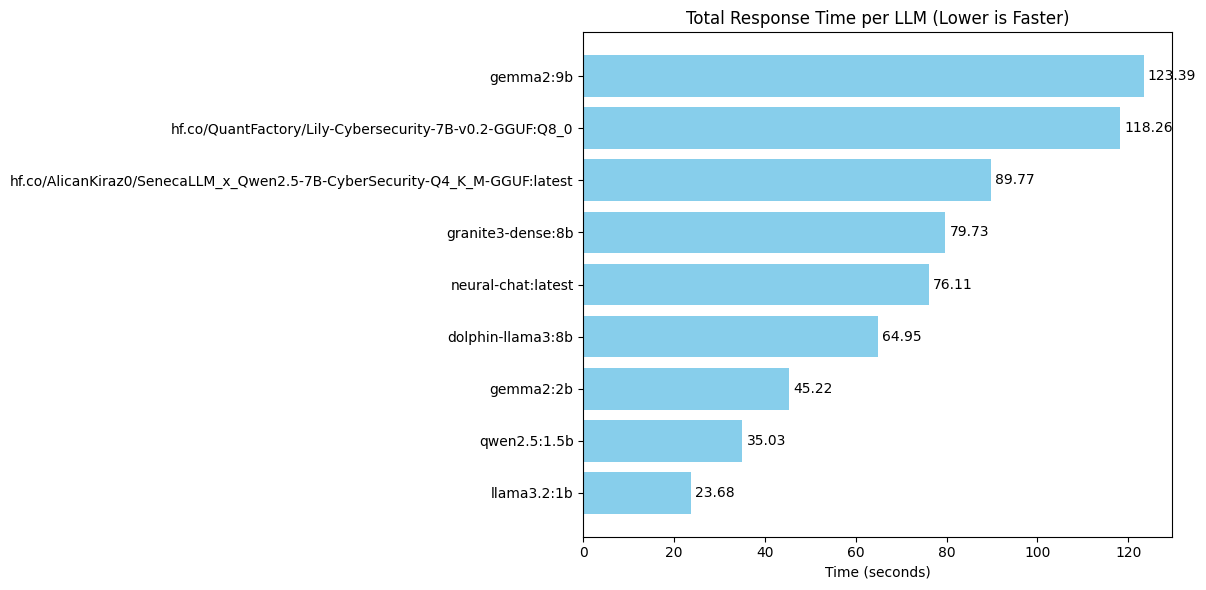

2025-04-09 17:57:04,684 - INFO - Plotting Average Response Rate per LLM (Higher is Faster): 9 models


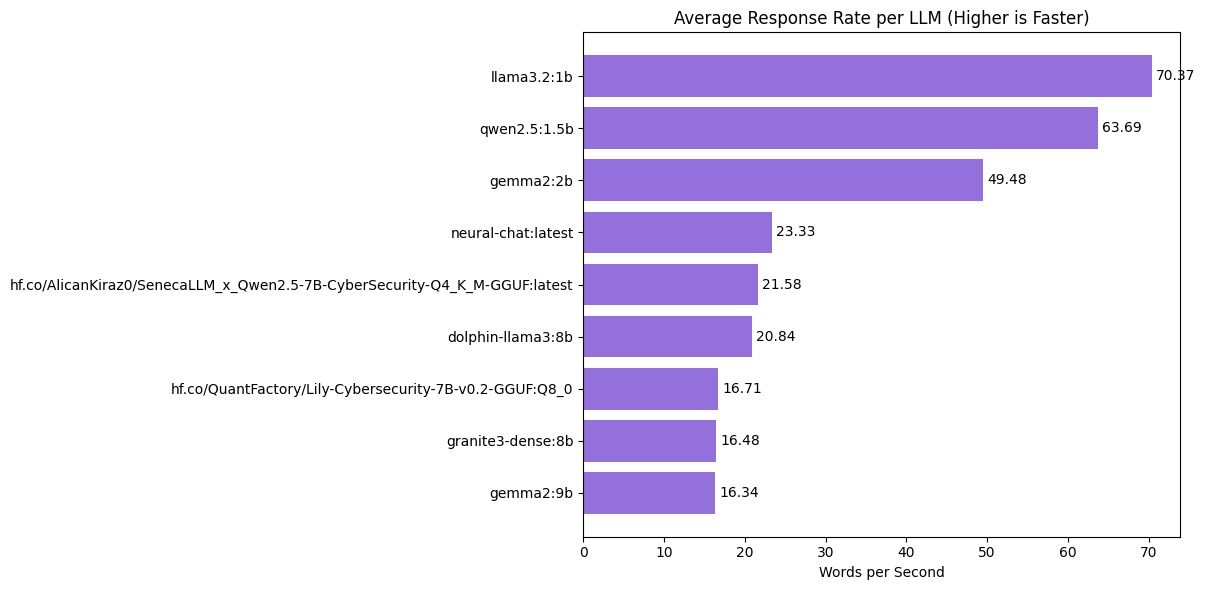

2025-04-09 17:57:04,729 - INFO - Plotting Total Word Count per LLM (Higher is More Verbose): 9 models


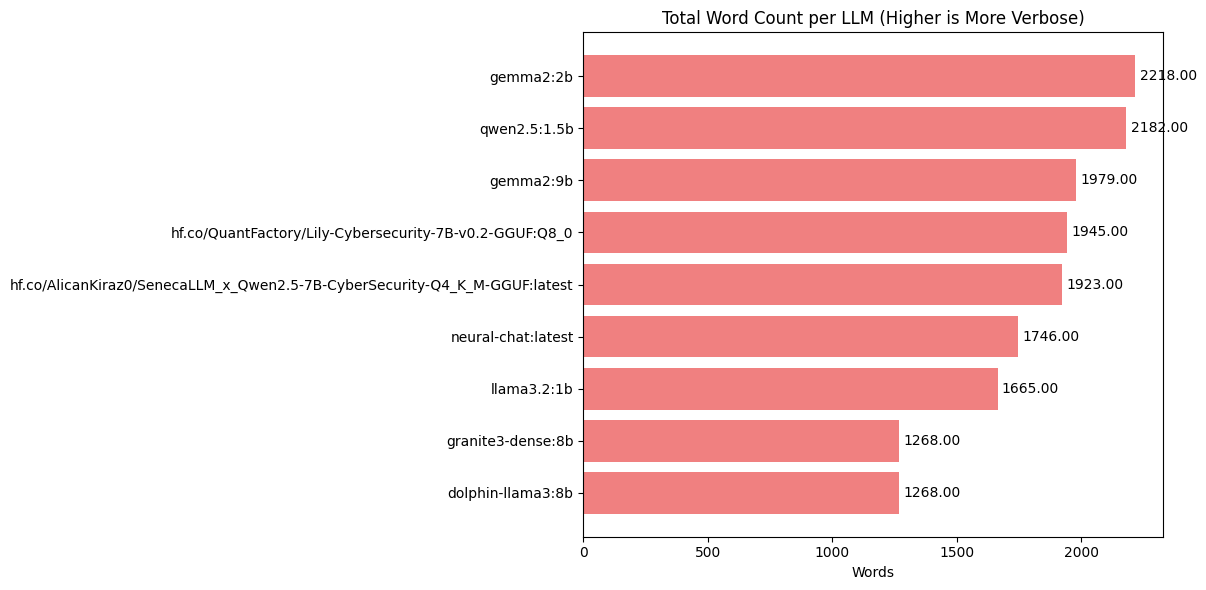

2025-04-09 17:57:04,772 - INFO - Plotting Total Character Count per LLM (Higher is More Verbose): 9 models


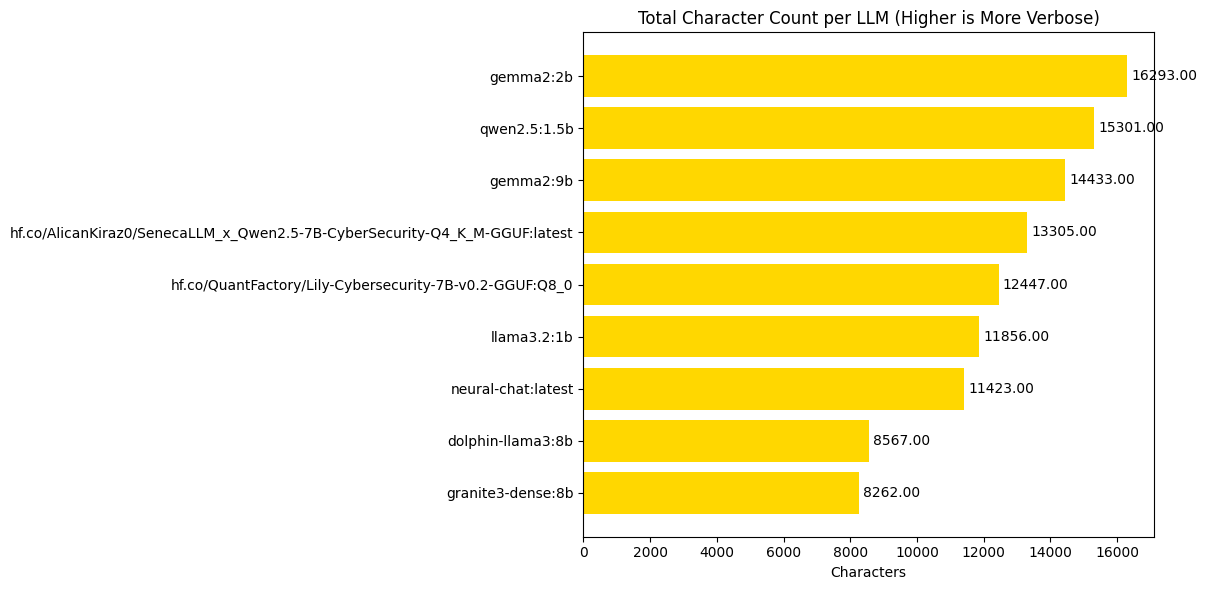

2025-04-09 17:57:04,821 - INFO - Plotting Total Sentence Count per LLM (Higher is More Verbose): 9 models


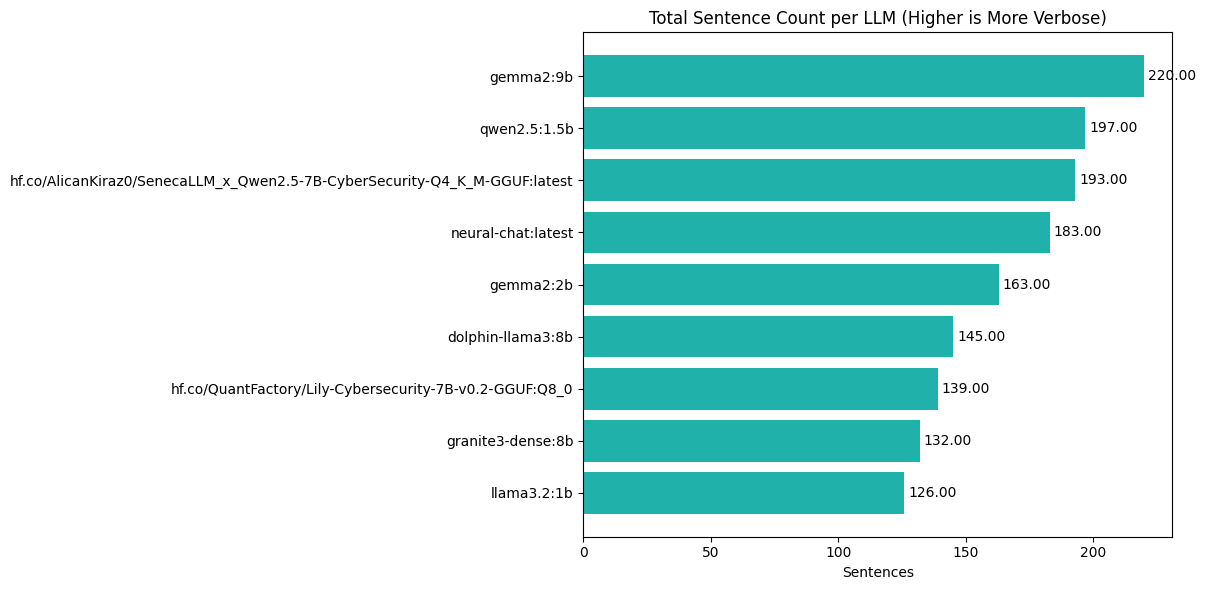

2025-04-09 17:57:04,864 - INFO - Plotting Average Word Length per LLM: 9 models


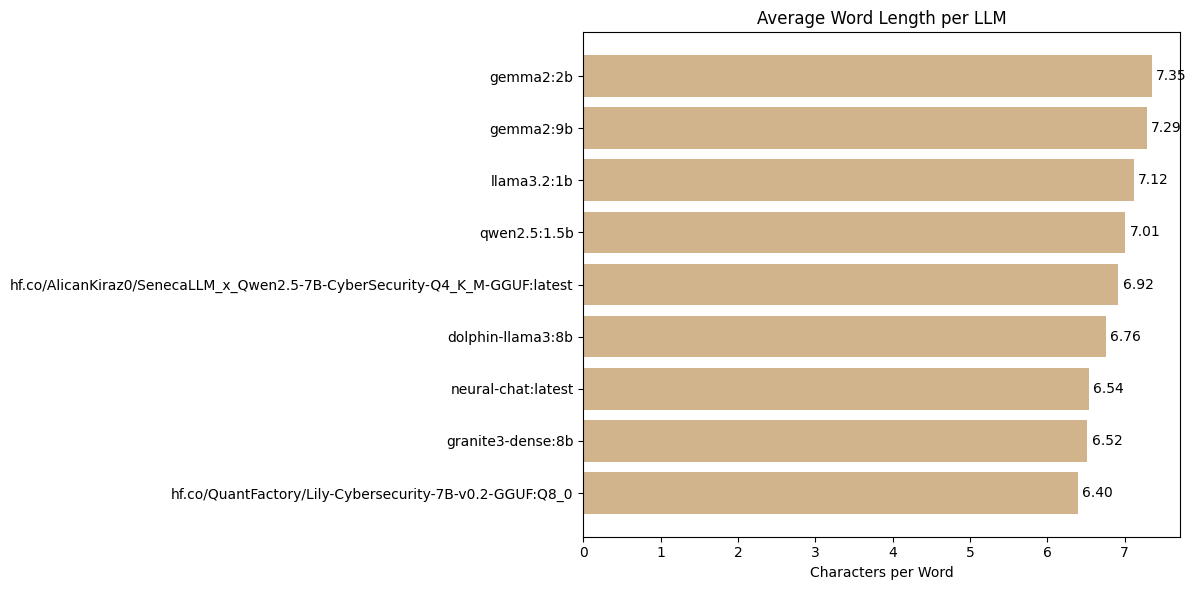

2025-04-09 17:57:04,908 - INFO - Plotting Average Sentence Length per LLM: 9 models


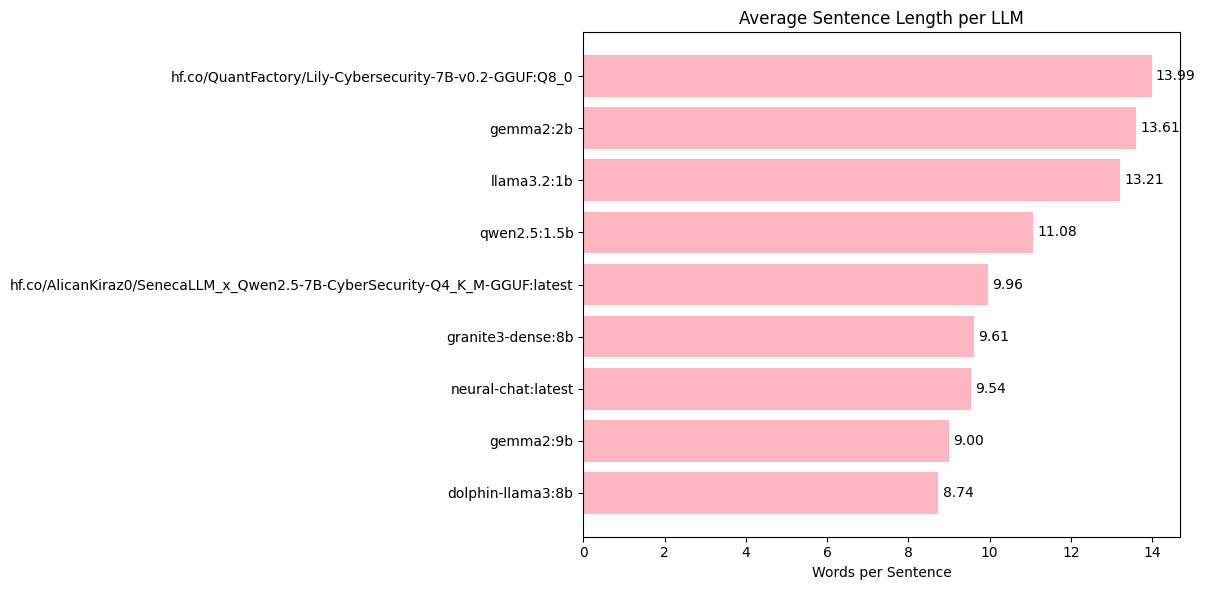

2025-04-09 17:57:04,951 - INFO - Plotting Average Vocabulary Richness per LLM: 9 models


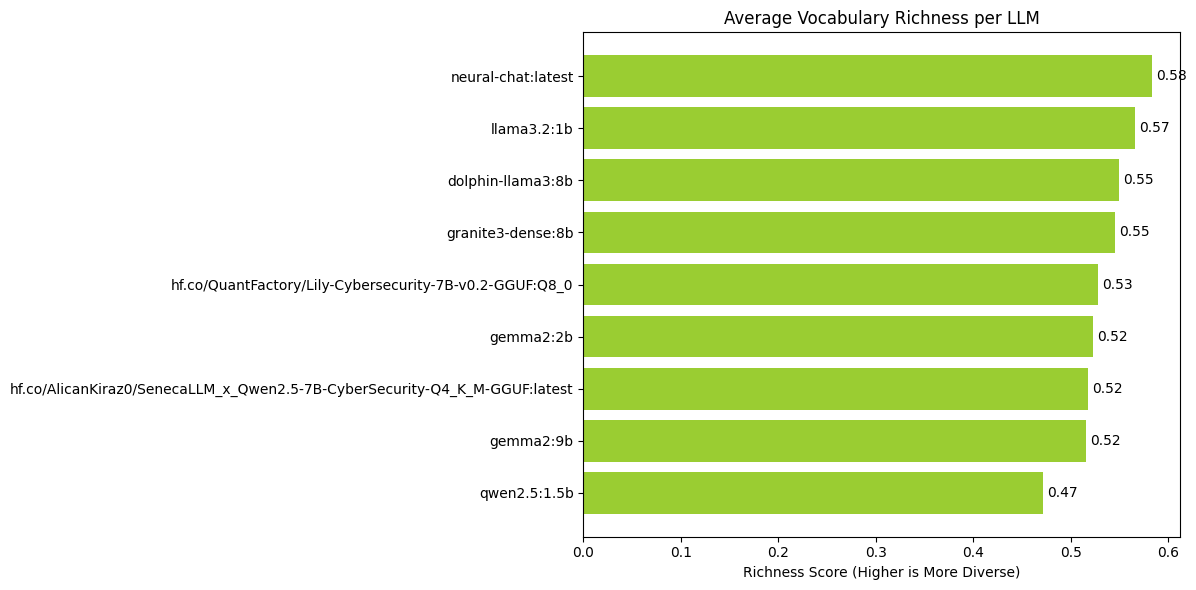

In [7]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Import numpy for handling potential NaN in plotting
import logging 

# --- Configuration ---
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the path to the directory containing the analysis results files
# This notebook is expected to be in the 'notebooks' directory.
# The analysis results are expected in '../analyzer/analysis_results/' relative to the notebook.
analysis_results_dir = '../analyzer/analysis_results/'

# --- Path Validation ---
# Convert the relative path to an absolute path for clarity and robustness
analysis_results_dir = os.path.abspath(analysis_results_dir)
if not os.path.isdir(analysis_results_dir):
    logging.error(f"Error: The directory {analysis_results_dir} does not exist.")
    # Depending on your notebook environment, you might want to stop execution here
    raise FileNotFoundError(f"Directory not found: {analysis_results_dir}")
else:
    logging.info(f"Searching for analysis files in: {analysis_results_dir}")

# --- Path Validation ---
analysis_results_dir = os.path.abspath(analysis_results_dir) # Convert to absolute path
if not os.path.isdir(analysis_results_dir):
    logging.error(f"Error: The directory {analysis_results_dir} does not exist.")
    # You might want to raise an error or exit here depending on the notebook context
    # raise FileNotFoundError(f"Directory not found: {analysis_results_dir}")
else:
    logging.info(f"Searching for analysis files in: {analysis_results_dir}")

    # --- Data Extraction ---
    # Define lists to store the metrics
    llm_names = []
    response_times = []
    chunk_times = []
    response_rates = []
    word_counts = []
    char_counts = []
    sentence_counts = []
    avg_word_lengths = []
    avg_sentence_lengths = []
    vocab_richnesses = []

    # Regular expressions to extract the metrics from the file content
    # These match the keys printed by consolidate_metrics
    metrics_regex = {
        'Total Elapsed Time': r"Total Elapsed Time:\s*([\d.]+)",
        'Average Response Rate': r"Average Response Rate:\s*([\d.]+)", # Renamed from 'Response Rate' to match output
        'Total Word Count': r"Total Word Count:\s*(\d+)", # Renamed from 'Word Count'
        'Total Character Count': r"Total Character Count:\s*(\d+)", # Renamed from 'Character Count'
        'Total Sentence Count': r"Total Sentence Count:\s*(\d+)", # Renamed from 'Sentence Count'
        'Average Word Length': r"Average Word Length:\s*([\d.]+)",
        'Average Sentence Length': r"Average Sentence Length:\s*([\d.]+)",
        'Average Vocabulary Richness': r"Average Vocabulary Richness:\s*([\d.]+)" # Renamed from 'Vocabulary Richness'

    }
    # Regex to extract the LLM model name from the header
    model_name_regex = r"Model Used:\s*(.*)"

    # Loop through all text files in the directory
    found_files = 0
    processed_files = 0
    for filename in os.listdir(analysis_results_dir):
        # Process only files matching the expected analysis output format
        if filename.endswith('.txt') and '_analysis_' in filename:
            found_files += 1
            file_path = os.path.join(analysis_results_dir, filename)
            logging.info(f"Processing file: {filename}")

            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()

                # 1. Extract LLM Name from content
                model_match = re.search(model_name_regex, content)
                if not model_match:
                    logging.warning(f"Could not find 'Model Used:' in file {filename}. Skipping.")
                    continue # Skip this file if model name is missing
                llm_name = model_match.group(1).strip()

                # 2. Extract Metrics from content
                extracted_metrics = {}
                metrics_found = True
                for key, regex in metrics_regex.items():
                    match = re.search(regex, content)
                    if match:
                        try:
                            # Attempt to convert to float immediately
                            extracted_metrics[key] = float(match.group(1))
                        except ValueError:
                             logging.warning(f"Could not convert value for '{key}' to float in {filename}. Skipping file.")
                             metrics_found = False
                             break # Stop processing metrics for this file
                    else:
                        logging.warning(f"Could not find metric '{key}' in file {filename}. Skipping file.")
                        metrics_found = False
                        break # Stop processing metrics for this file

                # Only append if all required metrics were found and valid
                if metrics_found:
                    llm_names.append(llm_name)
                    response_times.append(extracted_metrics.get('Total Elapsed Time', np.nan)) # Use np.nan for safety
                    # chunk_times.append(extracted_metrics.get('Average Chunk Time', np.nan)) # If added back
                    response_rates.append(extracted_metrics.get('Average Response Rate', np.nan))
                    word_counts.append(extracted_metrics.get('Total Word Count', np.nan))
                    char_counts.append(extracted_metrics.get('Total Character Count', np.nan))
                    sentence_counts.append(extracted_metrics.get('Total Sentence Count', np.nan))
                    avg_word_lengths.append(extracted_metrics.get('Average Word Length', np.nan))
                    avg_sentence_lengths.append(extracted_metrics.get('Average Sentence Length', np.nan))
                    vocab_richnesses.append(extracted_metrics.get('Average Vocabulary Richness', np.nan))
                    processed_files += 1
                else:
                     logging.warning(f"Skipped appending data for {filename} due to missing/invalid metrics.")

            except Exception as e:
                logging.error(f"Error processing file {filename}: {e}")
                continue # Skip to next file on general error

    logging.info(f"Found {found_files} potential analysis files. Successfully processed {processed_files}.")

    # --- DataFrame Creation and Processing ---
    if not llm_names:
        logging.error("No valid data extracted. Cannot create DataFrame or plots.")
    else:
        # Create a DataFrame
        metrics_df = pd.DataFrame({
            'LLM': llm_names,
            'Total Response Time': response_times,
            'Average Response Rate': response_rates,
            'Total Word Count': word_counts,
            'Total Character Count': char_counts,
            'Total Sentence Count': sentence_counts,
            'Average Word Length': avg_word_lengths,
            'Average Sentence Length': avg_sentence_lengths,
            'Average Vocabulary Richness': vocab_richnesses
        })

        # Convert columns to numeric (already attempted during extraction, but this handles potential NaNs)
        for column in metrics_df.columns[1:]:
            metrics_df[column] = pd.to_numeric(metrics_df[column], errors='coerce')

        # Remove rows with any NaN values that might have occurred
        original_rows = len(metrics_df)
        metrics_df.dropna(inplace=True)
        if len(metrics_df) < original_rows:
             logging.warning(f"Removed {original_rows - len(metrics_df)} rows with missing/invalid data after conversion.")

        # Aggregate metrics if multiple files used the same LLM (average)
        if not metrics_df.empty:
             logging.info("Aggregating metrics by LLM name (using mean)...")
             metrics_df = metrics_df.groupby('LLM', as_index=False).mean()

             logging.info("Final DataFrame for plotting:")
             print(metrics_df) # Display the aggregated data
             logging.info("Data types of the final DataFrame:")
             print(metrics_df.dtypes) # Display data types

             # --- Plotting ---
             def plot_metric(df, metric, color, ylabel, title, horizontal=False):
                 # Ensure the DataFrame is not empty before plotting
                 if df.empty:
                     logging.warning(f"Cannot plot '{title}': DataFrame is empty.")
                     return
                 # Ensure the metric column exists
                 if metric not in df.columns:
                      logging.warning(f"Cannot plot '{title}': Metric column '{metric}' not found in DataFrame.")
                      return

                 # Sort the DataFrame by the specified metric in ascending order
                 df_sorted = df.sort_values(by=metric, ascending=True)

                 sorted_llm_names = df_sorted['LLM'].tolist()
                 sorted_metric_values = df_sorted[metric].tolist()

                 logging.info(f"Plotting {title}: {len(sorted_llm_names)} models")
                 # print(list(zip(sorted_llm_names, sorted_metric_values))) # Optional: print sorted values

                 plt.figure(figsize=(12, max(6, len(sorted_llm_names) * 0.5))) # Adjust height based on number of models for barh
                 if horizontal:
                     bars = plt.barh(sorted_llm_names, sorted_metric_values, color=color)
                     plt.xlabel(ylabel)
                     # Add value labels to the bars
                     plt.bar_label(bars, fmt='%.2f', padding=3)
                 else:
                     bars = plt.bar(sorted_llm_names, sorted_metric_values, color=color)
                     plt.ylabel(ylabel)
                     plt.xticks(rotation=45, ha='right', fontsize=10)
                     # Add value labels to the bars
                     plt.bar_label(bars, fmt='%.2f', padding=3)

                 plt.title(title)
                 plt.tight_layout() # Adjust layout to prevent labels overlapping
                 plt.show()

             # Plot each metric (adjust column names if needed based on final DataFrame)
             plot_metric(metrics_df, 'Total Response Time', 'skyblue', 'Time (seconds)', 'Total Response Time per LLM (Lower is Faster)', horizontal=True)
             # plot_metric(metrics_df, 'Average Chunk Time', 'lightgreen', 'Time (seconds)', 'Average Chunk Time per LLM (Sorted)', horizontal=True) # If added back
             plot_metric(metrics_df, 'Average Response Rate', 'mediumpurple', 'Words per Second', 'Average Response Rate per LLM (Higher is Faster)', horizontal=True)
             plot_metric(metrics_df, 'Total Word Count', 'lightcoral', 'Words', 'Total Word Count per LLM (Higher is More Verbose)', horizontal=True)
             plot_metric(metrics_df, 'Total Character Count', 'gold', 'Characters', 'Total Character Count per LLM (Higher is More Verbose)', horizontal=True)
             plot_metric(metrics_df, 'Total Sentence Count', 'lightseagreen', 'Sentences', 'Total Sentence Count per LLM (Higher is More Verbose)', horizontal=True)
             plot_metric(metrics_df, 'Average Word Length', 'tan', 'Characters per Word', 'Average Word Length per LLM', horizontal=True)
             plot_metric(metrics_df, 'Average Sentence Length', 'lightpink', 'Words per Sentence', 'Average Sentence Length per LLM', horizontal=True)
             plot_metric(metrics_df, 'Average Vocabulary Richness', 'yellowgreen', 'Richness Score (Higher is More Diverse)', 'Average Vocabulary Richness per LLM', horizontal=True)

        else:
             logging.error("DataFrame is empty after processing and cleaning. No plots will be generated.")